In [ ]:
!pip install -r requirements.txt

In [50]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import awswrangler as wr
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [44]:
pd.set_option('display.float_format', '{:.2g}'.format)

In [5]:
df = wr.s3.read_parquet('s3://neon-datascience-sandbox/churn-cartoes/main')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2188874 entries, 0 to 2188873
Data columns (total 13 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   clientid                        Int64  
 1   ticket_mean_value               float64
 2   total_transactions              Int64  
 3   data_min                        string 
 4   data_max                        string 
 5   time_diff                       Int64  
 6   mean_time_between_transactions  float64
 7   presumedincome                  float64
 8   age                             float64
 9   ageneon                         Int64  
 10  GH_VL                           float64
 11  tempo_sem_transacao             Int64  
 12  churn_flag                      Int64  
dtypes: Int64(6), float64(5), string(2)
memory usage: 229.6 MB


## EDA: Pré análise para modelagem

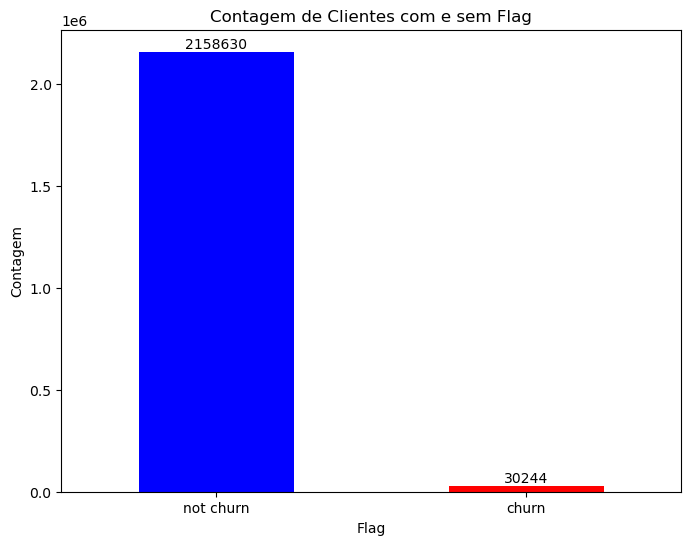

In [55]:
# Diferença entre clientes que tiveram e não tiveram churn
count_flag = df.churn_flag.value_counts()

plt.figure(figsize=(8, 6))
ax = count_flag.plot(kind='bar', color=['blue', 'red'])
# Personalizar o gráfico
plt.title('Contagem de Clientes com e sem Flag')
plt.xlabel('Flag')
plt.ylabel('Contagem')
plt.xticks(rotation=0)
plt.xticks([0, 1], ['not churn', 'churn'])
# Adicionar valores acima das barras
for i, v in enumerate(count_flag):
    ax.text(i, v + 10, str(v), color='black', ha='center', va='bottom')
# Exibir o gráfico
plt.show()

In [64]:
df_temp_0 = df[df['churn_flag'] == 0]
df_temp_sample_0 = df_temp_0.sample(n = 30244, random_state = 42)
df_temp_1 = df[df['churn_flag'] == 1]
df = pd.concat([df_temp_sample_0, df_temp_1])

In [80]:
for column in df.columns:
    df[column].fillna(np.mean(df[column]), inplace = True)

/opt/conda/envs/datalake/lib/python3.8/site-packages/pandas/core/series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [83]:
df.churn_flag.value_counts()

0    30244
1    30244
Name: churn_flag, dtype: Int64

# 1. Teste Comparativo:

In [121]:
X = df[features].astype('float64')
y = df[target].astype('float64')
y = y.values.ravel()
# Divida os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Crie e treine os modelos
models = {
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'Random Forest': RandomForestClassifier(random_state=42)
}
results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    results.append({'Model': model_name, 'Accuracy': accuracy, 'Classification Report': classification_rep})
# Crie um DataFrame para comparar os resultados
df_results = pd.DataFrame(results)
# Exiba os resultados
print(df_results)

[LightGBM] [Info] Number of positive: 24158, number of negative: 24232
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 48390, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499235 -> initscore=-0.003058
[LightGBM] [Info] Start training from score -0.003058
           Model  Accuracy                              Classification Report
0       LightGBM      0.84                precision    recall  f1-score   ...
1        XGBoost      0.83                precision    recall  f1-score   ...
2       CatBoost      0.84                precision    recall  f1-score   ...
3  Random Forest      0.84                precision    recall  f1-score   ...


In [122]:
results

[{'Model': 'LightGBM',
  'Accuracy': 0.8388163332782278,
  'Classification Report': '              precision    recall  f1-score   support\n\n         0.0       0.89      0.77      0.83      6012\n         1.0       0.80      0.90      0.85      6086\n\n    accuracy                           0.84     12098\n   macro avg       0.84      0.84      0.84     12098\nweighted avg       0.84      0.84      0.84     12098\n'},
 {'Model': 'XGBoost',
  'Accuracy': 0.8330302529343693,
  'Classification Report': '              precision    recall  f1-score   support\n\n         0.0       0.88      0.77      0.82      6012\n         1.0       0.80      0.89      0.84      6086\n\n    accuracy                           0.83     12098\n   macro avg       0.84      0.83      0.83     12098\nweighted avg       0.84      0.83      0.83     12098\n'},
 {'Model': 'CatBoost',
  'Accuracy': 0.838237725243842,
  'Classification Report': '              precision    recall  f1-score   support\n\n         0.0  

# 2. Execução detalhada dos modelos:

## Random Forest Classifier

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
features = ['ticket_mean_value', 'total_transactions', 'mean_time_between_transactions', 'age', 'ageneon', 'GH_VL', 'presumedincome']
target = ['churn_flag']

In [103]:
X = df[features].astype('float64')
y = df[target].astype('float64')

x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, random_state = 42, test_size = 0.4)

/tmp/ipykernel_242/2830304124.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_random_forest.fit(x_treino, y_treino)


              precision    recall  f1-score   support

         0.0       0.87      0.77      0.82     12069
         1.0       0.80      0.89      0.84     12127

    accuracy                           0.83     24196
   macro avg       0.84      0.83      0.83     24196
weighted avg       0.84      0.83      0.83     24196



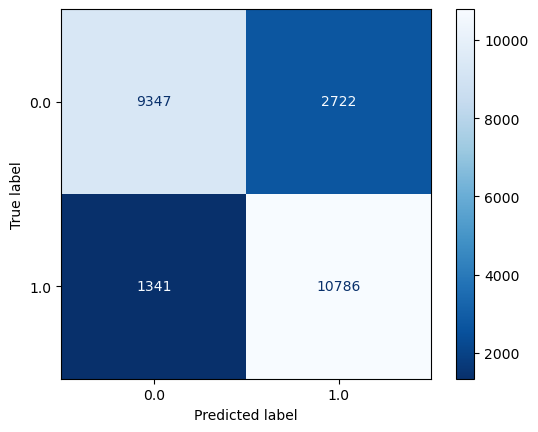

In [104]:
model_random_forest = RandomForestClassifier(random_state = 42, n_jobs = -1, max_depth= 10)

model_random_forest.fit(x_treino, y_treino)

print(metrics.classification_report(y_teste, model_random_forest.predict(x_teste)))

metrics.plot_confusion_matrix(model_random_forest, x_teste, y_teste,cmap='Blues_r')

## Lightgbm 

In [87]:
features = ['ticket_mean_value', 'total_transactions', 'mean_time_between_transactions', 'age', 'ageneon', 'GH_VL', 'presumedincome']
target = ['churn_flag']

In [88]:
base_treino = df.sample(frac=0.8,random_state=0)
base_teste = df.drop(base_treino.index)

In [89]:
Xtrain = base_treino[features].astype('float64')
ytrain = base_treino[target].astype('float64')

Xtest = base_teste[features].astype('float64')
ytest = base_teste[target].astype('float64')

In [90]:
model = lgbm.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(Xtrain,ytrain, eval_set=[(Xtest,ytest),(Xtrain,ytrain)], eval_metric='auc')

/opt/conda/envs/datalake/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Info] Number of positive: 24194, number of negative: 24196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 48390, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499979 -> initscore=-0.000083
[LightGBM] [Info] Start training from score -0.000083


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [91]:
print('Training accuracy {:.4f}'.format(model.score(Xtrain,ytrain)))
print('Testing accuracy {:.4f}'.format(model.score(Xtest,ytest)))
print(metrics.classification_report(ytest,model.predict(Xtest)))

Training accuracy 0.8469
Testing accuracy 0.8346
              precision    recall  f1-score   support

         0.0       0.89      0.77      0.82      6048
         1.0       0.79      0.90      0.85      6050

    accuracy                           0.83     12098
   macro avg       0.84      0.83      0.83     12098
weighted avg       0.84      0.83      0.83     12098



/opt/conda/envs/datalake/lib/python3.8/site-packages/lightgbm/plotting.py:381: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<AxesSubplot:>

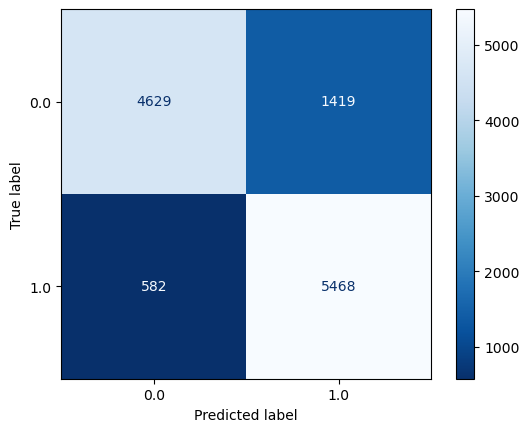

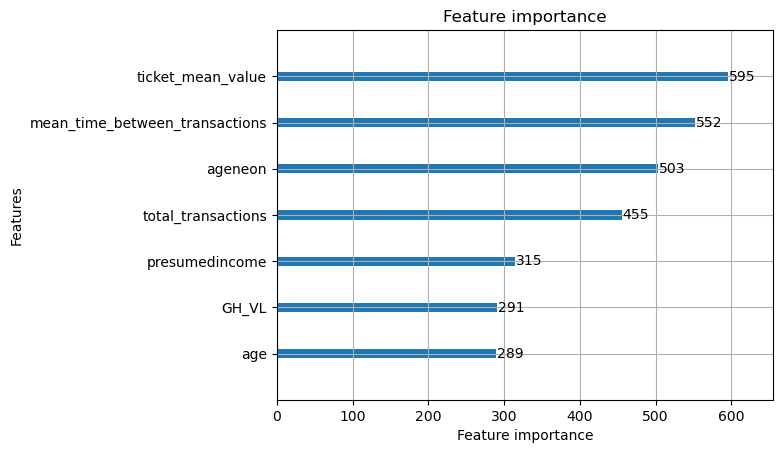

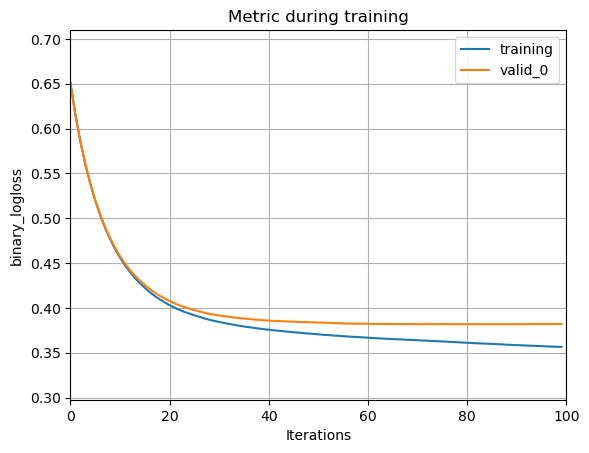

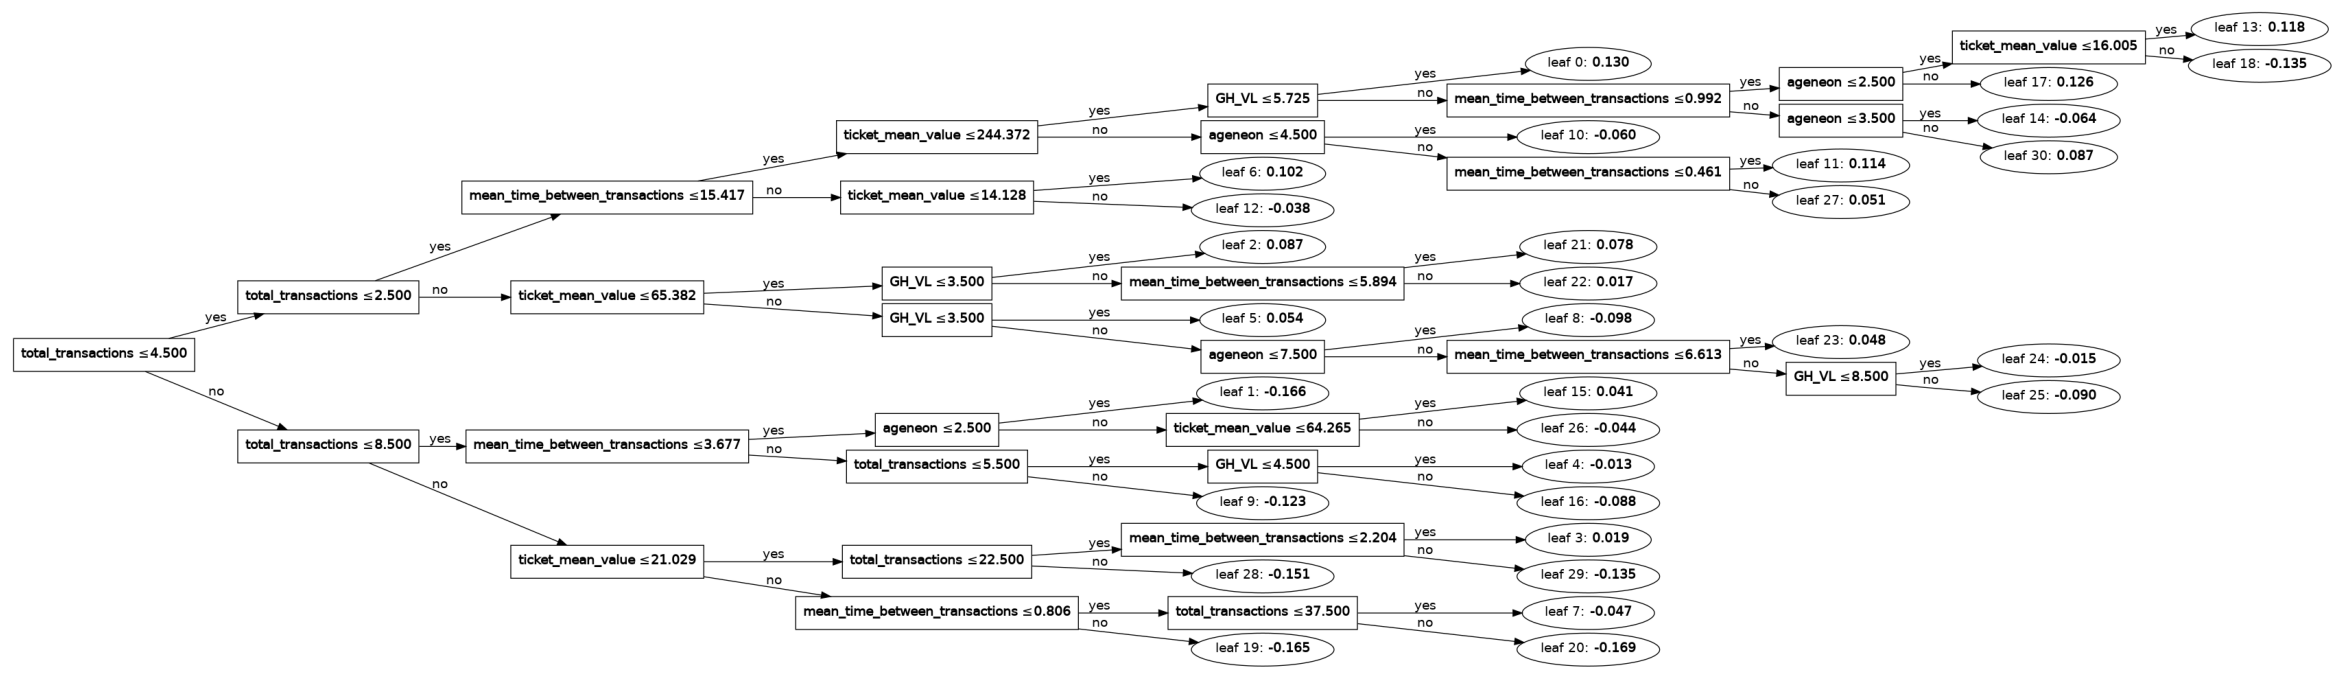

In [92]:
metrics.plot_confusion_matrix(model,Xtest,ytest,cmap='Blues_r')

lgbm.plot_importance(model)

lgbm.plot_metric(model)

lgbm.plot_tree(model,figsize=(30,40))

___

## Logistic Regression

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import f1_score

features = ['ticket_mean_value', 'total_transactions', 'mean_time_between_transactions', 'age', 'ageneon', 'GH_VL', 'presumedincome']
target = ['churn_flag']

X = base_treino[features].astype('float64')
y = base_treino[target].astype('float64')

X = X.fillna(X.mean())
y = y.fillna(y.mean())

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 42)

from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import f1_score

logReg = LR(verbose = True, solver = 'newton-cg')
logReg.fit(X_treino, y_treino)
y_pred = logReg.predict(X_teste)
y_pred_proba = logReg.predict_proba(X_teste)
f1 = f1_score(y_teste, y_pred)
print("f1_score: ",f1)

/opt/conda/envs/datalake/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


f1_score:  0.8311655512059603


_____

## Catboost

In [94]:
from catboost import CatBoostClassifier

In [95]:
features = ['ticket_mean_value', 'total_transactions', 'mean_time_between_transactions', 'age', 'ageneon', 'GH_VL', 'presumedincome']
target = ['churn_flag']

In [97]:
base_treino = df.sample(frac=0.8,random_state=0)
base_teste = df.drop(base_treino.index)

X_treino = base_treino[features].values
y_treino = base_treino[target].values


X_teste = base_teste[features].values
y_teste = base_teste[target].values


# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=100,
                           learning_rate=1,
                           depth=2)
# Fit model
model.fit(X_treino, y_treino, plot=True)
# Get predicted classes
preds_class = model.predict(X_teste)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(X_teste)
# Get predicted RawFormulaVal
preds_raw = model.predict(X_teste, prediction_type='RawFormulaVal')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4720576	total: 1.56ms	remaining: 155ms
1:	learn: 0.4467262	total: 3.06ms	remaining: 150ms
2:	learn: 0.4331685	total: 4.19ms	remaining: 135ms
3:	learn: 0.4263357	total: 5.28ms	remaining: 127ms
4:	learn: 0.4197486	total: 6.42ms	remaining: 122ms
5:	learn: 0.4171830	total: 7.5ms	remaining: 117ms
6:	learn: 0.4134442	total: 8.55ms	remaining: 114ms
7:	learn: 0.4117152	total: 9.53ms	remaining: 110ms
8:	learn: 0.4103107	total: 10.6ms	remaining: 107ms
9:	learn: 0.4093101	total: 11.6ms	remaining: 105ms
10:	learn: 0.4069069	total: 12.7ms	remaining: 103ms
11:	learn: 0.4062164	total: 13.7ms	remaining: 100ms
12:	learn: 0.4049070	total: 14.8ms	remaining: 98.8ms
13:	learn: 0.4027031	total: 15.8ms	remaining: 97.3ms
14:	learn: 0.4013356	total: 16.9ms	remaining: 95.6ms
15:	learn: 0.4008840	total: 17.9ms	remaining: 93.9ms
16:	learn: 0.4005544	total: 19ms	remaining: 92.5ms
17:	learn: 0.3996760	total: 20ms	remaining: 91.2ms
18:	learn: 0.3989697	total: 21.1ms	remaining: 89.8ms
19:	learn: 0.3985140

## Distribuição Exponencial

In [99]:
df

,ticket_mean_value,total_transactions,mean_time_between_transactions,age,ageneon,GH_VL,presumedincome,churn_flag
1411071,43,22,2.5,22,16,10,8.2e+02,0
226326,44,4,9.8,24,47,10,1.1e+03,0
92717,3.3e+02,7,7.7,32,54,10,1.6e+03,0
1193604,81,19,1.8,36,22,9,1.1e+03,0
1266416,1.9e+02,10,3.8,52,20,3,1.1e+03,0
...,...,...,...,...,...,...,...,...
2187362,0.9,11,0,32,2,7,1.3e+03,1
2188170,10,1,0,33,2,2,1.4e+03,1
2188260,10,1,0,18,2,5.4,0,1
2188495,10,1,0,25,2,6,8.9e+02,1


In [100]:
tempo_churn = 30
df['lambda'] = 1 / df['mean_time_between_transactions']
df['prob_churn_exp'] = 1 - np.exp(-df['lambda'] * 30)

/tmp/ipykernel_242/958636953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lambda'] = 1 / df['mean_time_between_transactions']
/tmp/ipykernel_242/958636953.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prob_churn_exp'] = 1 - np.exp(-df['lambda'] * 30)


In [101]:
df[df['churn_flag'] == 0].prob_churn_exp.describe()

count   3e+04
mean     0.98
std     0.038
min      0.65
25%      0.99
50%         1
75%         1
max         1
Name: prob_churn_exp, dtype: float64

In [115]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
# Gere dados de exemplo
# X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X = df[features].astype('float64')
y = df[target].astype('float64')
y = y.values.ravel()
# Divida os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Crie e treine os modelos
models = {
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'Random Forest': RandomForestClassifier(random_state=42)
}
results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    results.append({'Model': model_name, 'Accuracy': accuracy, 'Classification Report': classification_rep})
# Crie um DataFrame para comparar os resultados
df_results = pd.DataFrame(results)
# Exiba os resultados
print(df_results)

[LightGBM] [Info] Number of positive: 24158, number of negative: 24232
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 48390, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499235 -> initscore=-0.003058
[LightGBM] [Info] Start training from score -0.003058
           Model  Accuracy                              Classification Report
0       LightGBM      0.84                precision    recall  f1-score   ...
1        XGBoost      0.83                precision    recall  f1-score   ...
2       CatBoost      0.84                precision    recall  f1-score   ...
3  Random Forest      0.84                precision    recall  f1-score   ...


In [119]:
df_results['Classification Report']

0                  precision    recall  f1-score   ...
1                  precision    recall  f1-score   ...
2                  precision    recall  f1-score   ...
3                  precision    recall  f1-score   ...
Name: Classification Report, dtype: object

In [120]:
results

[{'Model': 'LightGBM',
  'Accuracy': 0.8388163332782278,
  'Classification Report': '              precision    recall  f1-score   support\n\n         0.0       0.89      0.77      0.83      6012\n         1.0       0.80      0.90      0.85      6086\n\n    accuracy                           0.84     12098\n   macro avg       0.84      0.84      0.84     12098\nweighted avg       0.84      0.84      0.84     12098\n'},
 {'Model': 'XGBoost',
  'Accuracy': 0.8330302529343693,
  'Classification Report': '              precision    recall  f1-score   support\n\n         0.0       0.88      0.77      0.82      6012\n         1.0       0.80      0.89      0.84      6086\n\n    accuracy                           0.83     12098\n   macro avg       0.84      0.83      0.83     12098\nweighted avg       0.84      0.83      0.83     12098\n'},
 {'Model': 'CatBoost',
  'Accuracy': 0.838237725243842,
  'Classification Report': '              precision    recall  f1-score   support\n\n         0.0  